# Project 6: IMDB

This project involves NLP, decision trees, bagging, boosting, and more!

---

## Load packages

You are likely going to need to install the `imdbpie` package:

    > pip install imdbpie

---

In [1]:
%%bash
pip install imdbpie

You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import os
import subprocess
import collections
import re
import csv
import json

import pandas as pd
import numpy as np
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import psycopg2
import requests
from imdbpie import Imdb
import nltk

import urllib
from bs4 import BeautifulSoup
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

---

## Part 1: Acquire the Data

You will connect to the IMDB API to query for movies. 

See here for documentation on how to use the package:

https://github.com/richardasaurus/imdb-pie

#### 1. Connect to the IMDB API

In [3]:
from imdbpie import Imdb

imdb = Imdb()
imdb = Imdb(anonymize=True)

#### 2. Query the top 250 rated movies in the database

In [4]:
top = imdb.top_250()

#### 3. Make a dataframe from the movie data

Keep the fields:

    num_votes
    rating
    tconst
    title
    year
    
And discard the rest

In [5]:
top_df = {'num_votes':[],'rating':[],'tconst':[],'title':[],'year':[]}  # create dictionary
for i in top:  #iterate through top 250 movies
    top_df['num_votes'].append(i['num_votes'])  #append values to appropriate dictionary keys
    top_df['rating'].append(i['rating'])
    top_df['tconst'].append(i['tconst'])
    top_df['title'].append(i['title'])
    top_df['year'].append(i['year'])

In [6]:
top_df = pd.DataFrame(top_df)
top_df.head()

num_votes  rating     tconst                     title  year
0    1661358     9.3  tt0111161  The Shawshank Redemption  1994
1    1137094     9.2  tt0068646             The Godfather  1972
2     776658     9.0  tt0071562    The Godfather: Part II  1974
3    1647046     9.0  tt0468569           The Dark Knight  2008
4     849965     8.9  tt0108052          Schindler's List  1993

#### 3. Select only the top 100 movies

In [7]:
top_100 = top_df.sort_values('rating', ascending = False)[0:100]   # order by rating and subset 100
top_100.head()

num_votes  rating     tconst  \
0    1661358     9.3  tt0111161   
1    1137094     9.2  tt0068646   
2     776658     9.0  tt0071562   
3    1647046     9.0  tt0468569   
7    1195590     8.9  tt0167260   

                                           title  year  
0                       The Shawshank Redemption  1994  
1                                  The Godfather  1972  
2                         The Godfather: Part II  1974  
3                                The Dark Knight  2008  
7  The Lord of the Rings: The Return of the King  2003

In [8]:
top_100.head()

num_votes  rating     tconst  \
0    1661358     9.3  tt0111161   
1    1137094     9.2  tt0068646   
2     776658     9.0  tt0071562   
3    1647046     9.0  tt0468569   
7    1195590     8.9  tt0167260   

                                           title  year  
0                       The Shawshank Redemption  1994  
1                                  The Godfather  1972  
2                         The Godfather: Part II  1974  
3                                The Dark Knight  2008  
7  The Lord of the Rings: The Return of the King  2003

#### 4. Get the genres and runtime for each movie and add them to the dataframe

There can be multiple genres per movie, so this will need some finessing.

In [9]:
import requests
import json

movies = {'genre': [], 'runtime':[]}   # create empty dictionary for genre runtime
for a in top_100.tconst:  # for each IMDB id
    path = "http://www.omdbapi.com/?i=%s&plot=short&r=json" % a   # parse through the paths of each id,
    #substituting the new id via the %s %sub method
    movie_dict = json.loads(requests.get(path).text)   #load the request data into json object
    movies['genre'].append(movie_dict['Genre'])   #append the genres, runtime to a dictionary
    movies['runtime'].append(movie_dict['Runtime'])
    
top_100['genre'] = movies['genre']   # finish dataframe
top_100['runtime'] = movies['runtime']

In [10]:
top_100.head()

num_votes  rating     tconst  \
0    1661358     9.3  tt0111161   
1    1137094     9.2  tt0068646   
2     776658     9.0  tt0071562   
3    1647046     9.0  tt0468569   
7    1195590     8.9  tt0167260   

                                           title  year  \
0                       The Shawshank Redemption  1994   
1                                  The Godfather  1972   
2                         The Godfather: Part II  1974   
3                                The Dark Knight  2008   
7  The Lord of the Rings: The Return of the King  2003   

                       genre  runtime  
0               Crime, Drama  142 min  
1               Crime, Drama  175 min  
2               Crime, Drama  202 min  
3    Action, Crime, Thriller  152 min  
7  Adventure, Drama, Fantasy  201 min

#### 4. Write the Results to a csv

In [11]:
#top_100.to_csv('../assets/data/top_100.csv', encoding = 'utf-8')

---

## Part 2: Wrangle the text data

#### 1. Scrape the reviews for the top 100 movies

*Hint*: Use a loop to scrape each page at once

In [12]:
from scrapy.selector import Selector
from scrapy.http import HtmlResponse
reviews = []
import urllib
reviews_dict = {'tconst' : [],'best':[],'best_rate':[]}
            
testing = np.linspace(1,19,10)
print testing
for index in top_100.tconst:
    
    #top 10 best
    path = 'http://www.imdb.com/title/%s/reviews?filter=best' % index
    print path
    response = requests.get(path)
    HTML = response.text
        
    for r in range(1,11):   # starts at p1
        reviews = Selector(text=HTML).xpath("//div[@id='tn15content']/p[%s]/text()" % r).extract()
        reviews_dict['tconst'].append(index)
        reviews_dict['best'].append(reviews)
                #getting star rating        
    for i in testing:
        if Selector(text=HTML).xpath("//div[@id='tn15content']/div[%s]/img/@alt" % i).extract() == []:
          # place holder
            reviews_dict['best_rate'].append(['-1/10'])
        else:
            reviews_dict['best_rate'].append(Selector(text=HTML).xpath("//div[@id='tn15content']/div[%s]/img/@alt" % i).extract())
    
   

[  1.   3.   5.   7.   9.  11.  13.  15.  17.  19.]
http://www.imdb.com/title/tt0111161/reviews?filter=best
http://www.imdb.com/title/tt0068646/reviews?filter=best
http://www.imdb.com/title/tt0071562/reviews?filter=best
http://www.imdb.com/title/tt0468569/reviews?filter=best
http://www.imdb.com/title/tt0167260/reviews?filter=best
http://www.imdb.com/title/tt0137523/reviews?filter=best
http://www.imdb.com/title/tt0060196/reviews?filter=best
http://www.imdb.com/title/tt0110912/reviews?filter=best
http://www.imdb.com/title/tt0050083/reviews?filter=best
http://www.imdb.com/title/tt0108052/reviews?filter=best
http://www.imdb.com/title/tt0120737/reviews?filter=best
http://www.imdb.com/title/tt0080684/reviews?filter=best
http://www.imdb.com/title/tt0109830/reviews?filter=best


KeyboardInterrupt: 

In [ ]:
reviews_df = pd.DataFrame(reviews_dict)
reviews_df.shape

#### 2. Extract the reviews and the rating per review for each movie

*Note*: "soup" from BeautifulSoup is the html returned from all 25 pages. You'll need to either address each page individually or break them down by elements.

In [ ]:
from string import ascii_letters, digits

In [ ]:
reviews_df.best

#### 3. Remove the non AlphaNumeric characters from reviews

In [ ]:
import re
reviews_df.best = reviews_df.best.apply(lambda x: [s.encode('UTF8') for s in x])

reviews_df.best = reviews_df.best.apply(lambda x: str(x).replace('\\n', ' '))
            
reviews_df.best = reviews_df.best.apply(lambda x: re.sub(r'([^\s\w]|_)+', '', str(x)))

In [ ]:
reviews_df.best.shape

#### 4. Calculate the top 200 ngrams from the user reviews

Use the `TfidfVectorizer` in sklearn.

Recommended parameters:

    ngram_range = (1, 2)
    stop_words = 'english'
    binary = False
    max_features = 200

In [ ]:
#%debug
best = reviews_df.best 
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(ngram_range=(1,2), stop_words='english', binary = False, max_features = 200)
X = tvec.fit_transform(best)
indices = np.argsort(tvec.idf_)[::-1]
features = tvec.get_feature_names()
counts = tvec.inverse_transform(X)
top_n = 200
top_features = [features[i] for i in indices[:top_n]]
print top_features

# counts = tvec.inverse_transform(X)
# top_counts = [counts[i] for i in indices[:top_n]]
# print top_counts

# ask dave how to get counts in a dataframe, counts and words


#### 5. Merge the user reviews and ratings

In [ ]:
reviews_df.head()

#### 6. Save this merged dataframe as a csv

In [377]:
reviews_df.to_csv('../assets/data/top_reviews.csv', encoding = 'utf-8')

---

## Part 3: Combine Tables in PostgreSQL

#### 1. Import your two .csv data files into your Postgre Database as two different tables

For ease, we can call these table1 and table2

In [13]:
#table1 = pd.read_csv('../assets/data/top_100.csv')
#table2 = pd.read_csv('../assets/data/top_reviews.csv')
#table1.columns = [c.lower() for c in table1.columns] #postgres doesn't like capitals or spaces
#table2.columns = [c.lower() for c in table2.columns]
from sqlalchemy import create_engine
engine = create_engine('postgresql://Stav@localhost:5432/imdb')

#table1.to_sql("table1", engine)
#table2.to_sql("table2",engine)

#### 2. Connect to database and query the joined set

In [90]:
sql = """
SELECT * FROM table1 WHERE "rating" > 5

"""

top_100 = pd.read_sql(sql,engine)

#### 3. Join the two tables 

In [15]:
sql = """
SELECT "num_votes",table1."tconst","title","year","genre","runtime","best","best_rate","rating"
FROM table1 LEFT JOIN table2 ON table1.tconst = table2.tconst LIMIT 5

"""

pd.read_sql(sql,engine)

num_votes     tconst                     title  year         genre  \
0    1658688  tt0111161  The Shawshank Redemption  1994  Crime, Drama   
1    1658688  tt0111161  The Shawshank Redemption  1994  Crime, Drama   
2    1658688  tt0111161  The Shawshank Redemption  1994  Crime, Drama   
3    1658688  tt0111161  The Shawshank Redemption  1994  Crime, Drama   
4    1658688  tt0111161  The Shawshank Redemption  1994  Crime, Drama   

   runtime                                               best best_rate  \
0  142 min   Why do I want to write the 234th comment on T...   [10/10]   
1  142 min    Can Hollywood usually creating things for en...   [10/10]   
2  142 min    I have never seen such an amazing film since...   [-1/10]   
3  142 min   In its Oscar year Shawshank Redemption writte...   [10/10]   
4  142 min   The reason I became a member of this database...   [-1/10]   

   rating  
0     9.3  
1     9.3  
2     9.3  
3     9.3  
4     9.3

#### 4. Select the newly joined table and save two copies of the into dataframes

In [16]:
sql = """
SELECT "num_votes",table1."tconst","title","year","genre","runtime","best","best_rate","rating"
FROM table1 LEFT JOIN table2 ON table1.tconst = table2.tconst
"""

merged_df = pd.read_sql(sql,engine)

In [17]:
merged_df.head()

num_votes     tconst                     title  year         genre  \
0    1658688  tt0111161  The Shawshank Redemption  1994  Crime, Drama   
1    1658688  tt0111161  The Shawshank Redemption  1994  Crime, Drama   
2    1658688  tt0111161  The Shawshank Redemption  1994  Crime, Drama   
3    1658688  tt0111161  The Shawshank Redemption  1994  Crime, Drama   
4    1658688  tt0111161  The Shawshank Redemption  1994  Crime, Drama   

   runtime                                               best best_rate  \
0  142 min   Why do I want to write the 234th comment on T...   [10/10]   
1  142 min    Can Hollywood usually creating things for en...   [10/10]   
2  142 min    I have never seen such an amazing film since...   [-1/10]   
3  142 min   In its Oscar year Shawshank Redemption writte...   [10/10]   
4  142 min   The reason I became a member of this database...   [-1/10]   

   rating  
0     9.3  
1     9.3  
2     9.3  
3     9.3  
4     9.3

---

## Part 4: Parsing and Exploratory Data Analysis

#### 1. Rename any columns you think should be renamed for clarity

In [18]:
merged_df.rename(columns={'tconst':'id'}, inplace=True)
merged_df.columns

Index([u'num_votes',        u'id',     u'title',      u'year',     u'genre',
         u'runtime',      u'best', u'best_rate',    u'rating'],
      dtype='object')

#### 2. Describe anything interesting or suspicious about your data (quality assurance)

In [19]:
merged_df.isnull().sum()  # nothing seems that suspicious about the data

num_votes    0
id           0
title        0
year         0
genre        0
runtime      0
best         0
best_rate    0
rating       0
dtype: int64

#### 3. Make four visualizations of interest to you using the data

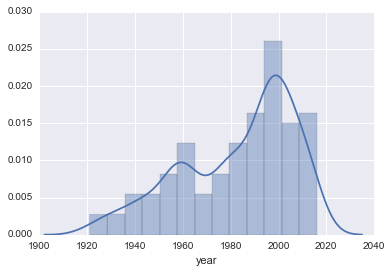

In [20]:
sns.distplot(merged_df.year)

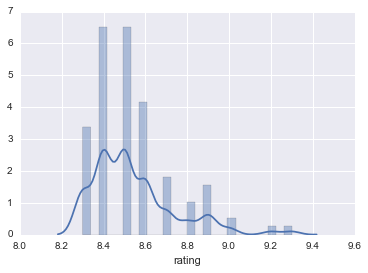

In [21]:
#rating plot
sns.distplot(merged_df.rating)

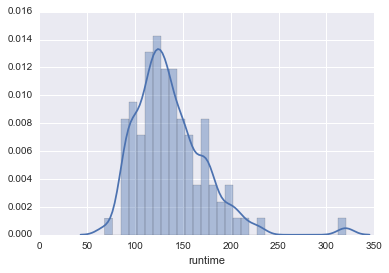

In [22]:
#runtime plot
merged_df.runtime = merged_df.runtime.apply(lambda x: float((x.replace('min',''))))
sns.distplot(merged_df.runtime)

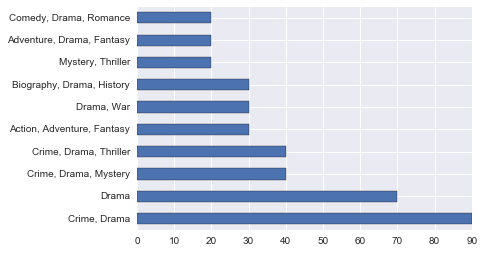

In [23]:
merged_df.genre.value_counts()[0:10].plot(kind = 'barh')

---

## Part 5: Decision Tree Classifiers and Regressors

#### 1. What is our target attribute? 

Choose a target variable for the decision tree regressor and the classifier. 

In [24]:
merged_df.head(15)

num_votes         id                                           title  \
0     1658688  tt0111161                        The Shawshank Redemption   
1     1658688  tt0111161                        The Shawshank Redemption   
2     1658688  tt0111161                        The Shawshank Redemption   
3     1658688  tt0111161                        The Shawshank Redemption   
4     1658688  tt0111161                        The Shawshank Redemption   
5     1658688  tt0111161                        The Shawshank Redemption   
6     1658688  tt0111161                        The Shawshank Redemption   
7     1658688  tt0111161                        The Shawshank Redemption   
8      820511  tt0080684  Star Wars: Episode V - The Empire Strikes Back   
9     1658688  tt0111161                        The Shawshank Redemption   
10    1658688  tt0111161                        The Shawshank Redemption   
11    1135329  tt0068646                                   The Godfather   
12    1135329  tt0068646                                   The Godfather   
13    1135329  tt0068646                                   The Godfather   
14    1135329  tt0068646                                   The Godfather   

    year                       genre  runtime  \
0   1994                Crime, Drama    142.0   
1   1994                Crime, Drama    142.0   
2   1994                Crime, Drama    142.0   
3   1994                Crime, Drama    142.0   
4   1994                Crime, Drama    142.0   
5   1994                Crime, Drama    142.0   
6   1994                Crime, Drama    142.0   
7   1994                Crime, Drama    142.0   
8   1980  Action, Adventure, Fantasy    124.0   
9   1994                Crime, Drama    142.0   
10  1994                Crime, Drama    142.0   
11  1972                Crime, Drama    175.0   
12  1972                Crime, Drama    175.0   
13  1972                Crime, Drama    175.0   
14  1972                Crime, Drama    175.0   

                                                 best best_rate  rating  
0    Why do I want to write the 234th comment on T...   [10/10]     9.3  
1     Can Hollywood usually creating things for en...   [10/10]     9.3  
2     I have never seen such an amazing film since...   [-1/10]     9.3  
3    In its Oscar year Shawshank Redemption writte...   [10/10]     9.3  
4    The reason I became a member of this database...   [-1/10]     9.3  
5     I believe that this film is the best story e...    [8/10]     9.3  
6     One of my all time favorites Shawshank Redem...   [10/10]     9.3  
7     One of the finest films made in recent years...   [10/10]     9.3  
8    An excellent sequel to Star Wars this is easi...    [9/10]     8.8  
9    Misery and Stand By Me were the best adaptati...   [10/10]     9.3  
10    The Shawshank Redemption is without a doubt ...   [10/10]     9.3  
11   Rather than concentrating on everything that ...   [10/10]     9.2  
12    This is by far the best movie ever to give a...   [10/10]     9.2  
13    The Godfather is one of the few films in whi...   [10/10]     9.2  
14         This movie is strong good script great ...   [10/10]     9.2

In [25]:
x = merged_df.best
np.arange(0,1010,10)


array([   0,   10,   20,   30,   40,   50,   60,   70,   80,   90,  100,
        110,  120,  130,  140,  150,  160,  170,  180,  190,  200,  210,
        220,  230,  240,  250,  260,  270,  280,  290,  300,  310,  320,
        330,  340,  350,  360,  370,  380,  390,  400,  410,  420,  430,
        440,  450,  460,  470,  480,  490,  500,  510,  520,  530,  540,
        550,  560,  570,  580,  590,  600,  610,  620,  630,  640,  650,
        660,  670,  680,  690,  700,  710,  720,  730,  740,  750,  760,
        770,  780,  790,  800,  810,  820,  830,  840,  850,  860,  870,
        880,  890,  900,  910,  920,  930,  940,  950,  960,  970,  980,
        990, 1000])

#### 2. Prepare the X and Y matrices and preprocess data as you see fit

In [70]:
merged_df['is_comedy'] = [1 if 'Comedy' in index else 0 for index in merged_df.genre]
merged_df.head()
merged_df.is_comedy.value_counts()

0    870
1    130
Name: is_comedy, dtype: int64

In [29]:
merged_df.head()
merged_df.best_rate = merged_df.best_rate.apply(lambda x: x.replace('[','').replace(']','') )
merged_df.best_rate = merged_df.best_rate.apply(lambda x: float((x.split('/')[0]))/float((x.split('/')[1])))

In [30]:
merged_df[['best', 'best_rate']]
print merged_df['best_rate'].value_counts()


merged_df.best_rate = merged_df.best_rate.apply(lambda x: np.nan if x == -0.1 else x)


 1.0    598
-0.1    215
 0.9    106
 0.8     39
 0.1     28
 0.7      6
 0.3      3
 0.2      2
 0.5      2
 0.4      1
Name: best_rate, dtype: int64


In [31]:
sentiment_df = merged_df[['best', 'best_rate','is_comedy','title','genre']]

In [32]:
sentiment_df.columns = ['review','review_rate','is_comedy','title','genre']
#sentiment_df[sentiment_df.is_comedy == 1]

review  review_rate  \
107    Charlie Chaplins study of a tramp teaming up...          NaN   
155   This movie surprised us We checked on IMDb an...          0.9   
156   In less than two months Untouchable became th...          1.0   
168   Well Ive just got out of the theater and i mu...          1.0   
169   Its not because Im French that I appreciated ...          1.0   
216   Just seen last night amazing movie great perf...          1.0   
243   Part satire part slapstick comedy part melodr...          0.9   
244    Charlie Chaplins Modern Times 1936 is the fi...          1.0   
245    Modern Times is in my top 5 films and 2 in m...          1.0   
246    It is a testament to Chaplins filmmaking ski...          1.0   
247    This movie is a must see for anyone who love...          1.0   
248    Hilarious touching anarchic revolutionary re...          NaN   
249   It is difficult to review Chaplins movies obj...          1.0   
250   Favorite Chaplin film Packed with social comm...          1.0   
251   The Tramp Charlie Chaplin is just a cog in th...          0.9   
252    Long after most people thought the silent mo...          NaN   
253   If there is one Charlie Chaplin film to recom...          1.0   
254    Chaplin takes himself a little more seriousl...          1.0   
255   Once again Chaplin plays his famous creation ...          0.9   
256   This is my favorite Chaplin film but I dont w...          NaN   
257   Let me join the consensus and call Charlie Ch...          NaN   
258   CITY LIGHTS United Artists 1931 written direc...          NaN   
259   City Lights is simply put one of the best mov...          0.9   
260    Charlie Chaplins City Lights contains a blen...          NaN   
261   I always thought this was one of Charlie Chap...          0.9   
262    Film has become a medium that is strongly in...          NaN   
291   Do not look at this through the prism of Fore...          1.0   
292   I am now trying to find words to describe thi...          1.0   
293   Being french and a film maker myself I have h...          NaN   
294   It has been 9 weeks now since Intoucblaes has...          1.0   
..                                                 ...          ...   
865    Admittedly biased Some Like It Hot can certa...          1.0   
891    One of the all time great screen comedies So...          1.0   
892   Some people still say this is the greatest co...          1.0   
893    I just saw this movie for the first time and...          1.0   
894   Why a man would want to marry another man ask...          1.0   
895    What Jack Lemmon and Tony Curtis do in Some ...          NaN   
896   Any camera loved Marilyn the bestxc2x85 In al...          0.8   
897    Sit back and enjoy this comedy I dont believ...          NaN   
898    A Comedy that has it all and lacks absolutel...          NaN   
899    Some Like it Hot will have a Danish repremie...          NaN   
910   talk about lack luster in this movie and lack...          0.1   
911   I am genuinely confused as to why people are ...          0.1   
922   I was luckily able to catch a screening a few...          1.0   
923   I was lucky enough to get a ticket to a speci...          1.0   
924   UP Pixars latest animated feature is just del...          1.0   
925   Carl Frederickson Ed Asner has lived a long l...          1.0   
926   If theres a list of great computer animation ...          NaN   
927   Viewed at the Festival de Cannes 2009  The op...          NaN   
929   If Pixar  as a studio  has any weakness its t...          1.0   
930   Greetings again from the darkness Another cra...          0.8   
931   What can I say about Pixar Amazing Perfect Go...          1.0   
932   Seriously Im convinced Pixar is maybe the onl...          1.0   
955   Where to begin with DisneyPixars Inside Out I...          0.1   
956   I have not seen every Disney Pixar film The o...          0.1   
957   The film was awful and extremely boring It wa...          0.1   
9

In [105]:
joined_movies = []

for movie in sentiment_df.title.unique():
    joined_movies.append([movie, "".join(sentiment_df[sentiment_df['title'] == movie]['review'])])
    
joined_reviews = pd.DataFrame(joined_movies)


In [106]:
joined_reviews.columns = ['title','review']

In [107]:
joined_reviews['genre'] = top_100.genre

In [108]:
joined_reivews['genre'] == top_100.genre

NameError: name 'joined_reivews' is not defined

In [75]:
joined_reviews.columns = ['title','review','is_comedy','genre']
joined_reviews.is_comedy.value_counts()

Crime, Drama                  50
Adventure, Drama, Fantasy     15
Action, Crime, Thriller       10
Western                       10
Drama                         10
Biography, Drama, History      3
Action, Adventure, Fantasy     2
Name: is_comedy, dtype: int64

In [77]:
joined_reviews

title  \
0                            The Shawshank Redemption   
1      Star Wars: Episode V - The Empire Strikes Back   
2                                       The Godfather   
3                                    Schindler's List   
4                              The Godfather: Part II   
5                                     The Dark Knight   
6   The Lord of the Rings: The Fellowship of the Ring   
7       The Lord of the Rings: The Return of the King   
8                                          Fight Club   
9                                        Pulp Fiction   
10                     The Good, the Bad and the Ugly   
11                                       12 Angry Men   
12                                            The Kid   
13                                 Lawrence of Arabia   
14                                       Forrest Gump   
15                                 American History X   
16                                      Seven Samurai   
17                                          Inception   
18                                        City of God   
19                                          Star Wars   
20                                   The Intouchables   
21              The Lord of the Rings: The Two Towers   
22                                         Goodfellas   
23                                         The Matrix   
24                    One Flew Over the Cuckoo's Nest   
25                                       Interstellar   
26                                Saving Private Ryan   
27                                 The Usual Suspects   
28                       Once Upon a Time in the West   
29                                        The Message   
..                                                ...   
70                                       A Separation   
71                        Witness for the Prosecution   
72                              To Kill a Mockingbird   
73                                             Aliens   
74                                Requiem for a Dream   
75                                  Princess Mononoke   
76                                     Reservoir Dogs   
77                                 North by Northwest   
78         Star Wars: Episode VI - Return of the Jedi   
79                                             WALL·E   
80                                             Oldboy   
81                                           Das Boot   
82                                       Citizen Kane   
83                                    American Beauty   
84                                            Vertigo   
85                        Once Upon a Time in America   
86                                        The Shining   
87                         Captain America: Civil War   
88                                   Some Like It Hot   
89                                        Tokyo Story   
90                              Judgment at Nuremberg   
91                                         Inside Out   
92                                  Good Will Hunting   
93                                                 Up   
94                                 Gangs of Wasseypur   
95                                      The Third Man   
96                                           Downfall   
97                                        Raging Bull   
98                                            Sunrise   
99                                   The Great Escape   

                                               review  \
0    Why do I want to write the 234th comment on T...   
1    An excellent sequel to Star Wars this is easi...   
2    Rather than concentrating on everything that ...   
3    When I first saw that Spielberg was behind th...   
4     This movie is way to be good to be labelled ...   
5    Weve been subjected to enormous amounts of hy...   
6     but oh was I thankful for it All through the...   
7     Peter Jackson has done it  He has created an...   


In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

vct = TfidfVectorizer(stop_words="english")
matrix = vct.fit_transform(joined_reviews[joined_reviews['is_comedy'] == 1].review)
freqs = [(word, matrix.getcol(idx).sum()) for word, idx in vct.vocabulary_.items()]
#sort from largest to smallest
print sorted (freqs, key = lambda x: -x[1])[:75]



ValueError: empty vocabulary; perhaps the documents only contain stop words

In [95]:
from sklearn.linear_model import LogisticRegression

# Preprocess our text data to Tfidf
tfv = TfidfVectorizer(lowercase=True, strip_accents='unicode')
X_all = tfv.fit_transform(sentiment_df['review'])

# Setup logistic regression (or try another classification method here)
estimator = LogisticRegression()
estimator.fit(X_all, sentiment_df['is_comedy'])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [135]:
# Prep our source as TfIdf vectors
source_test = sentiment_df.review[243:245]

############
# NOTE:  Do not re-initialize the tfidf vectorizor or the feature space willbe overwritten and
# hence your transform will not match the number of features you trained your model on.
#
# This is why you only need to "transform" since you already "fit" previously
#
####

X_all = tfv.transform(source_test)

# Predict using previously trained logist regression `estimator`
print estimator.predict_proba(X_all)[:,1:]
print estimator.predict(X_all)

[[ 0.53781731]
 [ 0.39668663]]
[1 0]


#### 3. Build and cross-validate your decision tree classifier

#### 4. Gridsearch optimal parameters for your classifier. Does the performance improve?

#### 5. Build and cross-validate your decision tree regressor

#### 6. Gridsearch the optimal parameters for your classifier. Does performance improve?

---

## Part 6: Elastic Net


#### 1. Gridsearch optimal parameters for an ElasticNet using the regression target and predictors you used for the decision tree regressor.


#### 2. Is cross-validated performance better or worse than with the decision trees? 

#### 3. Explain why the elastic net may have performed best at that particular l1_ratio and alpha

---

## Part 7: Bagging and Boosting: Random Forests, Extra Trees, and AdaBoost

#### 1. Load the random forest regressor, extra trees regressor, and adaboost regressor from sklearn

#### 2. Gridsearch optimal parameters for the three different ensemble methods.

#### 3. Evaluate the performance of the two bagging and one boosting model. Which performs best?

#### 4. Extract the feature importances from the Random Forest regressor and make a DataFrame pairing variable names with their variable importances.

#### 5. Plot the ranked feature importances.

#### 6.1 [BONUS] Gridsearch an optimal Lasso model and use it for variable selection (make a new predictor matrix with only the variables not zeroed out by the Lasso). 

#### 6.2 [BONUS] Gridsearch your best performing bagging/boosting model from above with the features retained after the Lasso. Does the score improve?

#### 7.1. [BONUS] Select a threshold for variable importance from your Random Forest regressor and use that to perform feature selection, creating a new subset predictor matrix.

#### 7.2 [BONUS] Using BaggingRegressor with a base estimator of your choice, test a model using the feature-selected dataset you made in 7.1

---

## [VERY BONUS] Part 8: PCA

#### 1. Perform a PCA on your predictor matrix

#### 2. Examine the variance explained and determine what components you want to keep based on them.

#### 3. Plot the cumulative variance explained by the ordered principal components.

#### 4. Gridsearch an elastic net using the principal components you selected as your predictors. Does this perform better than the elastic net you fit earlier?

#### 5. Gridsearch a bagging ensemble estimator that you fit before, this time using the principal components as predictors. Does this perform better or worse than the original? 

#### 6. Look at the loadings of the original predictor columns on the first 3 principal components. Is there any kind of intuitive meaning here?

Hint, you will probably want to sort by absolute value of magnitude of loading, and also only look at the obviously important (larger) ones!

# [Extremely Bonus] Part 9:  Clustering

![](https://snag.gy/jPSZ6U.jpg)

 ***Bonus Bonus:***
This extended bonus question is asking to do something we never really talked about but would like for you to attempt based on the assumptions that we learned during this weeks clustering lesson(s).

#### 1. Import your favorite clustering module

#### 2. Encode categoricals

#### 3. Evaluate cluster metics solely based on a range of K
If K-Means:  SSE/Inertia vs Silhouette (ie: Elbow), silhouette average, etc

#### 4.  Look at your data based on the subset of your predicted clusters.
Assign the cluster predictions back to your dataframe in order to see them in context.  This is great to be able to group by cluster to get a sense of the data that clumped together.

#### 5. Describe your findings based on the predicted clusters 
_How well did it do?  What's good or bad?  How would you improve this? Does any of it make sense?_